<a href="https://colab.research.google.com/github/edwinsolisf/MLNuclearBindingEnergy/blob/master/Nuclear_Binding_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import the utilities and common machine learning libraries:
  - Panda: used for reading the CSV files
  - Numpy: used for fast math operations
  - Sklearn: used for the linear and polynomial regression as well as data separation
  - Scipy: used for the optimization algorithms:
  - Matplotlib: used to display graphs for the outputs


These are all common and important imports when performing machine learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from mendeleev import element
from google.colab import files
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px

from scipy.optimize import minimize

To obtain the data, we can fetch the periodic table of elements from the web. Then we generated our own csv file that included the binding energies as calculated with $E = mc^2$. From the csv (which was orginally generated in a seperate python documentation) we generated a list of tuples with the number of protons, number of nucleons (protons + nucleons), and the binding energy of the isotope. 

In [ ]:
# Form an array of binding energies using B = c^2 * (Atom mass - Sum of Nucleon Masses)
#Masses in GeV
pMass = 0.938
nMass = 0.939
GeVPerAmu = 0.931

isoarray = []
for i in range(118):
  i += 1
  elem = element(i)
  for iso in elem.isotopes:
    bindEnergy = (iso.atomic_number * pMass) + (iso.mass_number - iso.atomic_number)*nMass - iso.mass_number * GeVPerAmu
    isoarray.append([iso.atomic_number,iso.mass_number, iso.mass, bindEnergy, iso.is_radioactive])

out = pd.DataFrame(isoarray, columns = ['Proton Number','Nucleon Number','Mass', 'Binding Energy', 'Is Unstable'])
#out.to_csv("BindingEnergy.csv") 

In [ ]:
def get_periodic_table():
    url = "https://raw.githubusercontent.com/CorbinDPacheco/prog/main/Periodic%20Table%20of%20Elements.csv"
    periodic_table_csv = pd.read_csv(url)
    symbol_table = periodic_table_csv['Symbol']
    periodic_table = {}

    for i in range(len(periodic_table_csv['AtomicNumber'])):
        periodic_table[symbol_table[i].strip()] = i + 1

    return periodic_table

In [ ]:
def get_binding_table():
    '''
    Returns a list with tuples of the Proton Number, Nucleon Number, and Binding Energy in that order
    '''
    url = "https://raw.githubusercontent.com/CorbinDPacheco/prog/main/OGBindingEnergy.csv"
    isotope_table_csv = pd.read_csv(url)
    isotope_table = []

    for i in range(len(isotope_table_csv['Proton Number'])):
        isotope_table.append((isotope_table_csv['Proton Number'][i], isotope_table_csv['Nucleon Number'][i], isotope_table_csv['Binding Energy'][i] * 1000))

    return isotope_table

For the first model, we will try to fit a polynomial to the nuclear binding energy of the isotopes and try to obtain a good relationship for the data.
From the theoretical model given by the semi-empirical formula, we can try to take advantage of its mathematical structure to have a better model.

If we note that most of the non-integer order term are fractional with a cube root in them, we can see that a fit against a cube root of the nucleon terms will give us a polynomial-like equation with the biggest term being at most 3 for the nucleons and 2 for the protons. Hence, we can first try to use a third-degree polynomial for this.

In [ ]:
def binding_regression():
    '''
    Fitting binding energy to a 3rd degree polynomial using linear regression 
    '''
    table = get_binding_table()

    X = []
    Y = []
    for elem in table:
        X.append([elem[0], elem[1] ** (1./3.)])
        Y.append(elem[2])

    X = np.array(X)
    Y = np.array(Y)

    X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

    pipeline = make_pipeline(PolynomialFeatures(3), LinearRegression())
    pipeline.fit(X_train, Y_train)

    print("Intercept: ", pipeline.named_steps['linearregression'].intercept_)
    print("Coefficients ", pipeline.named_steps['linearregression'].coef_)
    print(pipeline.named_steps['polynomialfeatures'].powers_)
    print("Regression r-score: ", pipeline.score(x_test, y_test))

    x_test_nucleons = []
    for pair in x_test:
        x_test_nucleons.append(pair[1] ** 3.)

    figure, axis = plt.subplots(2)

    axis[0].scatter(x_test_nucleons, y_test, s=2, label = "True Values")
    axis[0].scatter(x_test_nucleons, pipeline.predict(x_test), s=1, label = "Predicted Values")
    axis[0].legend()
    axis[0].set_title("Binding Energy fit with 3rd degree Polynomial")
    axis[0].set_xlabel("Number of Nucleons")
    axis[0].set_ylabel("Binding Energy (MeV)")

    axis[1].scatter(x_test_nucleons, y_test / x_test_nucleons, s=2)
    axis[1].scatter(x_test_nucleons, pipeline.predict(x_test) / x_test_nucleons, s=1)
    axis[1].set_title("Binding Energy per Nucleon fit with 3rd degree Polynomial")
    axis[1].set_xlabel("Number of Nucleons")
    axis[1].set_ylabel("Binding Energy per nucelon (MeV/#num)")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

In this first model we note that near the smaller isotopes the graph for the nuclear binding energy per nucleon fails significantly to predict the correct values.

Therefore, for our second model, we can try an improve this by fiting the nuclear binding energy per nucleon instead of the regular binding energy.
For this one, again, using the theoretical prediction of the semi-empirical formula we can obtain a shape for this quantity and we can try the same trick as the previous model: fit against the cube root of the number of nucleons.

In [ ]:
def binding_per_nucleon_regression():
    '''
    Fitting binding energy per nucleon to a 5th degree polynomial using linear regression 
    '''
    table = get_binding_table()

    X = []
    Y = []
    for elem in table:
        X.append([elem[0], elem[1] ** (1./3.)])
        Y.append(elem[2] * elem[1] ** (1./3.))

    X = np.array(X)
    Y = np.array(Y)

    X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

    pipeline = make_pipeline(PolynomialFeatures(5), LinearRegression())
    pipeline.fit(X_train, Y_train)

    nucleons = []
    binding = Y_train
    predict_binding = pipeline.predict(X_train)
    binding_per_nucleon = []
    predict_binding_per_nucleon = []
    for i in range(len(X_train)):
        nucleons.append(X_train[i][1] ** 3.)
        predict_binding[i] = predict_binding[i] / nucleons[i] ** (1./3.)
        Y_train[i] = Y_train[i] / nucleons[i] ** (1./3.)
        binding_per_nucleon.append(Y_train[i] / nucleons[i])
        predict_binding_per_nucleon.append(predict_binding[i] / nucleons[i])

    print("Intercept: ", pipeline.named_steps['linearregression'].intercept_)
    coeff = pipeline.named_steps['linearregression'].coef_
    powers = pipeline.named_steps['polynomialfeatures'].powers_

    for i in range(len(coeff)):
        print(powers[i], coeff[i])
    print("Regression r-score: ", pipeline.score(x_test, y_test))

    fig, ax = plt.subplots(2)

    ax[0].scatter(nucleons, binding, s=2, label = "True Values")
    ax[0].scatter(nucleons, predict_binding, s=1, label = "Predicted Values")
    ax[0].legend()
    ax[0].set_title("Binding Energy fit with 5th degree Polynomial")
    ax[0].set_xlabel("Number of Nucleons")
    ax[0].set_ylabel("Binding Energy (MeV)")
  
    ax[1].scatter(nucleons, binding_per_nucleon, s=2)
    ax[1].scatter(nucleons, predict_binding_per_nucleon, s=1)
    ax[1].set_title("Binding Energy per nucleon fit with 5th degree Polynomial")
    ax[1].set_xlabel("Number of Nucleons")
    ax[1].set_ylabel("Binding Energy per nucelon (MeV/#num)")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

Finally, for the last models, we actually try to fit the data to the actual semi-empirical formula and obtain the coefficients for this equation.

To do this, we can try using optimization of parameters by minimizing the difference between the experimental binding energy and the theoretical predicted by the equation. By transforming this to a matrix-vector multiplication problem, if we form a matrix with the evaluated terms from the isotope data, and use the binding energy data as the output vector, we can try and find the input vector that will produce with least error the output vector with the matrix-vector multiplication. This way, we will find the coefficients that best fit the data and the semi-empirical formula.

For this case, we will use a quadratic error formula as the cost function, and use the local optimizer `SLSQP`.

In [ ]:
def binding_optimization():
    '''
    Fitting the coefficients of the semi-empirical formula
    '''
    table = get_binding_table()

    binding = []
    nucleons = []
    protons = []

    for elem in table:
        protons.append(elem[0])
        nucleons.append(elem[1])
        binding.append(elem[2])

    binding = np.array(binding)
    nucleons = np.array(nucleons)
    protons = np.array(protons)

    matrix = np.array([nucleons])
    matrix = np.concatenate((matrix, np.array([nucleons ** (2./3.)])), axis=0)
    matrix = np.concatenate((matrix, np.array([(nucleons ** (-1./3.)) * protons * (protons - 1)])), axis=0)
    matrix = np.concatenate((matrix, np.array([((nucleons - protons * 2) ** 2) / nucleons])), axis=0)
    pairing = nucleons ** (-3./4.)
    for i in range(len(pairing)):
        if nucleons[i] % 2 == 0 and int(protons[i]) % 2 == 1:
            pairing[i] = -pairing[i]
        elif nucleons[i] % 2 == 0:
            continue
        else:
            pairing[i] = 0
    matrix = np.concatenate((matrix, [pairing]), axis=0)
    matrix = np.ndarray.transpose(matrix)

    initial = np.random.rand(5) * 25
    temp = np.matmul(matrix, initial)

    def square_error(x):
        t = np.matmul(matrix, x)
        return np.sum((t - binding) ** 2)

    options={'eps': 1.49e-8, 'maxiter': 100000, 'disp': False, 'ftol': 0.0002}
    val = minimize(square_error, initial, method='SLSQP', options=options)
    params = val.x
    print(params)

    predict_binding = np.matmul(matrix, params)
    binding_per_nucleon = binding / nucleons
    predict_binding_per_nucleon = predict_binding / nucleons

    fig, ax = plt.subplots(2)

    ax[0].scatter(nucleons, binding, s=2, label = "True Values")
    ax[0].scatter(nucleons, predict_binding, s=1, label = "Predicted Values")
    ax[0].legend()
    ax[0].set_title("Binding Energy fit based on Semi-Empirical Formula")
    ax[0].set_xlabel("Number of Nucleons")
    ax[0].set_ylabel("Binding Energy (MeV)")
  
    ax[1].scatter(nucleons, binding_per_nucleon, s=2)
    ax[1].scatter(nucleons, predict_binding_per_nucleon, s=1)
    ax[1].set_title("Binding Energy per nucleon fit based on Semi-Empirical Formula")
    ax[1].set_xlabel("Number of Nucleons")
    ax[1].set_ylabel("Binding Energy per nucelon (MeV)")

    plt.subplots_adjust(hspace=0.7)
    plt.show()

    #Heatmaps 
    heatmap_data = pd.DataFrame()
    heatmap_data.insert(0, "Z", protons)
    heatmap_data.insert(1, "N", nucleons-protons)
    heatmap_data.insert(2, "(E/A) MeV", binding/nucleons)

    heatmap_data_temp = heatmap_data.pivot("Z", "N", "(E/A) MeV")
    heatmap_data_temp.sort_index(level=0, ascending=False, inplace=True)

    ax = sns.heatmap(heatmap_data_temp, vmin=-6, vmax=10,cbar_kws={'label': '(E/A) MeV'},xticklabels=20, yticklabels=20, cmap='hsv')
    ax.set_title('Binding Energy per Nucleon based on Atomic # and Nuetrons')
    plt.show()

    heatmap_data.drop(columns = ["(E/A) MeV"])
    heatmap_data.insert(2, "Predict (E/A) MeV",  predict_binding_per_nucleon)
    heatmap_data = heatmap_data.pivot("Z", "N", "Predict (E/A) MeV")
    heatmap_data.sort_index(level=0, ascending=False, inplace=True)
    ax = sns.heatmap(heatmap_data, vmin=-6, vmax=10,cbar_kws={'label': 'Predicted (E/A) MeV'},xticklabels=20, yticklabels=20, cmap='hsv')
    ax.set_title('Predicted Binding Energy per Nucleon based on Atomic # and Nuetrons')
    plt.show()

Next we explored the errors with different built in regression methods. 

First we explored scipy's polynomial regression. For this we set it up to follow the form of the semi-empirical binding energy formula to create another prediction for the coeficcents

In [ ]:
### POLYNOMIAL REGRESSION WITH SCIPY
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge
from scipy.optimize import curve_fit
import os

### READ DATA
data = pd.read_csv('https://raw.githubusercontent.com/CorbinDPacheco/prog/main/OGBindingEnergy.csv')
data = data[data['Binding Energy'] > 0]
data['Nucleon Number'] = data['Nucleon Number'].astype(int)
data['Proton Number'] = data['Proton Number'].astype(int)

### RETURN EQUATION WITH INPUT PARAMETERS TO FIT TO DATA
def semiEmpiricalBindingEnergyFit(X, a_v, a_s, a_c, a_sym, a_p):
    A, Z = X
    delta = np.array([1 if (A[i] % 2 == 0) and (Z[i] % 2 == 0) else -1 if (A[i] % 2 != 0) else 0 for i in range(len(A))])
    binding_energy = a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)*A**(-1/3) - a_sym*(A-2*Z)**2/A+delta*a_p*A**(-3/4)
    return binding_energy
    
### FIT ABOVE PARAMETERS TO DATA
popt, pcov = curve_fit(semiEmpiricalBindingEnergyFit, (data['Nucleon Number'],data['Proton Number']), data['Binding Energy'])
print(pcov)
popt = popt*1e3   #CONVERT FROM MeV TO keV
print(f"a_v = {popt[0]}\na_s = {popt[1]}\na_c = {popt[2]}\na_sym = {popt[3]}\na_p = {popt[4]}")

### PLOT PERCENT ERROR WITH SCIPY OPTIMIMAL COEFFICIENTS
def semiEmpiricalBindingEnergy(A, Z, a_v, a_s, a_c, a_sym, a_p):
    delta = np.array([1 if (A % 2 == 0) and (Z % 2 == 0) else -1 if (A % 2 != 0) else 0])
    binding_energy = a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)*A**(-1/3) - a_sym*(A-2*Z)**2/A+delta*a_p*A**(-3/4)
    return binding_energy
popt = popt*1e-3
err = []
for i in range(len(data['Binding Energy'])):
  NucNum = np.asarray(data['Nucleon Number'])[i]
  ProNum = np.asarray(data['Proton Number'])[i]
  bindEnergy = np.asarray(data['Binding Energy'])[i]
  error = np.abs((bindEnergy - semiEmpiricalBindingEnergy(NucNum,ProNum,popt[0],popt[1],popt[2],popt[3],popt[4]))/bindEnergy)
  err.append(error)
err = np.array(err)
print(err.shape,NucNum.shape)
plt.scatter(data['Nucleon Number'],err,) 
plt.xlabel('Nucleon Number')
plt.ylabel('Percent Error')
plt.title('Error with Scipy')
plt.show()

Then we explored the error with stocastic gradient descent. 

In [ ]:
### LINEAR REGRESSION WITH STOCHASTIC GRADIENT DESCENT (SGD)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
### IMPORT DATA
DS = pd.read_csv('https://raw.githubusercontent.com/CorbinDPacheco/prog/main/OGBindingEnergy.csv')
X0 = DS['Proton Number'].astype('int')
X1 = DS['Nucleon Number'].astype('int')
y = DS['Binding Energy']

### CREATE TWO-COLUMN MATRIX WITH PROTON NUMBER, NUCLEON NUMBER FOR EACH ROW
X01 = []
for i in range(len(X0)):
    X01.append([X0[i],X1[i]])
  
### CREATE AND FIT PIPELINE TO DATA
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter = 1000, tol = 1e-3))
reg.fit(X01,y)
reg.predict([[4,12]])


### PERCENT ERROR WITH SGD REGRESSION
err = []
for i in range(len(DS['Binding Energy'])-1):
    error = np.abs((DS['Binding Energy'][i+1] - reg.predict([[X0[i+1],X1[i+1]]]))/DS['Binding Energy'][i+1])
    err.append(error)
err = np.array(err)
DS['Nucleon Number'].pop(0)
plt.scatter(DS['Nucleon Number'],err) 
plt.xlabel('Nucleon Number')
plt.ylabel('Percent Error')
plt.title('Error with SGD')
plt.show()

Here we print out the actual results of our algorithm which we have better presented in our powerpoint 

Intercept:  155.06403739236407
Coefficients  [ 0.00000000e+00 -5.90450635e+01 -2.44521493e+02 -8.19434271e-01
  2.63140512e+01  1.55510558e+02 -9.87298020e-05  6.96342349e-02
 -8.67436689e-01 -2.51502221e+01]
[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]
Regression r-score:  0.9995577283514738


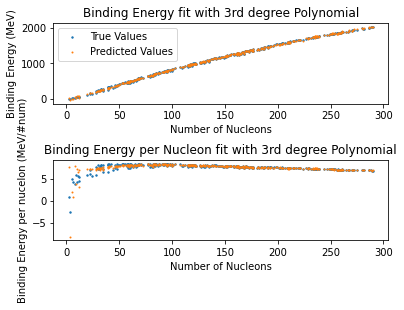

Intercept:  38.636642185476376
[0 0] 0.0
[1 0] 346.5410509605562
[0 1] -167.86706634262484
[2 0] -2.2160512354649793
[1 1] -557.1115679386729
[0 2] 8.126993780621444
[3 0] 0.23816772180367077
[2 1] -11.18976259658182
[1 2] 318.1263148787285
[0 3] 152.5547588689745
[4 0] 0.0019002217866131497
[3 1] -0.16546418135438487
[2 2] 4.716499871611346
[1 3] -62.32145483957317
[0 4] -81.41711884243219
[5 0] 4.523584243453474e-06
[4 1] -0.000555363556458285
[3 2] 0.025028607147738136
[2 3] -0.493024601195402
[1 4] 4.008900576679667
[0 5] 9.694670498115654
Regression r-score:  0.9999893147987042


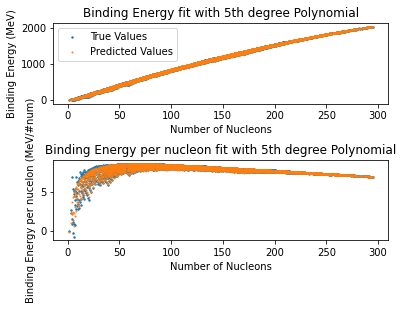

[ 15.04143779 -16.1310376   -0.68529289 -21.74703673  19.76020526]


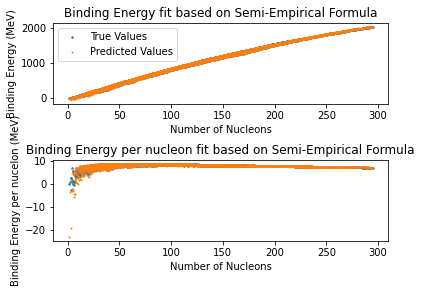

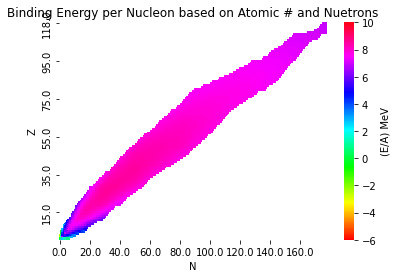

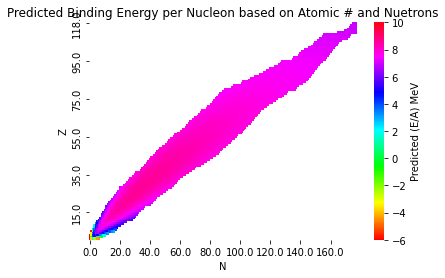

In [ ]:
def main():
    binding_regression()
    binding_per_nucleon_regression()
    binding_optimization()


if __name__ == '__main__':
    main()